In [27]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim

import torchvision.transforms as T
import torch.nn.functional as F


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
## data generation

# sample random x
def sample_x(num_samples):
    return np.random.normal(0.,1.,[num_samples,1])

# smaple y based on x : y = x + noise
def sample_y_x(x, num_samples, noise_var):
    return x + np.random.normal(0.,np.sqrt(noise_var),[num_samples,1])

In [47]:
num_samples = 500
noise_var = 2.0

x = sample_x(num_samples)
y = sample_y_x(x, num_samples, noise_var)

mi = 1/2 *(np.log(1 + ( 1/noise_var )))
print('the theoretical mi: {}'.format(mi))


the theoretical mi: 0.2027325540540822


## Divergence estimation 
Training a discriminator has been shown to be equivalent to compute  a certain divergence between two distributions p(x) and q(x).


$JSD(p(x) , q(x)) = E_{p(x)} [ log(1 - D(x)) ] + E_{q(x)} [ log(D(x)) ]$


$KL(p(x) , q(x))= E_{p(x)} [D(x)] - E_{q(x)} [ exp(D(x)) ] + 1$


$Wasserstein(p(x) , q(x) = E_{p(x)} [D(x)] - E_{q(x)}[D(x)]$

## MI estimation

mutual information betwwen two random variables $x_1$ and $x_2$ is defind as:

$MI(x_1, x_2) = D( p(x_1,x_2) || p(x_1) * p(x_2) ) $

- Joint sampling $(x_1, x_2) \sim p(x_1, x_2)$ following some joint distribution $p(x_1, x_2)$

- Independant sampling $x_1 \sim p(x_1), x_2 \sim p(x_2)$ obtained simply by shuffling the pairs in the batch

In [32]:
class MIEstimator1(nn.Module):
    def __init__(self, d):
        super(MIEstimator1, self).__init__()
        self.fc1 = nn.Linear(1, d)
        self.fc2 = nn.Linear(1, d)
        self.fc3 = nn.Linear(d, 1)

    def forward(self, x, y):
        x = self.fc1(x)
        y = self.fc2(y)
        out = F.relu(x + y)
        out = self.fc3(out)
        return out  
    
class MIEstimator2(nn.Module):
    def __init__(self, size1, size2, d):
        super(MIEstimator2, self).__init__()

        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(size1 + size2, d),
            nn.ReLU(True),
            nn.Linear(d, d),
            nn.ReLU(True),
            nn.Linear(d, 1),
        )

    # Gradient for JSD mutual information estimation and EB-based estimation
    def forward(self, x1, x2):
        pos = self.net(torch.cat([x1, x2], 1))  # Positive Samples
        neg = self.net(torch.cat([torch.roll(x1, 1, 0), x2], 1))
        grad = -F.softplus(-pos).mean() - F.softplus(neg).mean()
        out = pos.mean() - neg.exp().mean() + 1
        return grad, out

In [36]:
# evaluating the first model
num_samples = 10000
model = MIEstimator1(10)
n_epoch = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mi_hist = []
for epoch in range(n_epoch):
    x_sample = sample_x(num_samples)
    y_sample = sample_y_x(x_sample, num_samples, noise_var)
    y_shuffle = np.random.permutation(y_sample)
    
    x_sample = torch.from_numpy(x_sample).type(torch.FloatTensor)
    y_sample = torch.from_numpy(y_sample).type(torch.FloatTensor)
    y_shuffle = torch.from_numpy(y_shuffle).type(torch.FloatTensor)  
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    loss = - (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
    mi_hist.append(-1 * loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

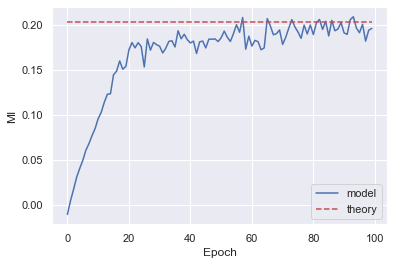

In [44]:
sns.set()
mi_theory = [mi] * len(mi_hist)

plt.plot(range(0, n_epoch), mi_hist, 'b-', label='model')
plt.plot(range(0, n_epoch), mi_theory, 'r--', label='theory')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MI')
plt.show()

In [40]:
# evaluating the second model

num_samples = 10000
model = MIEstimator2(1, 1, 10)
n_epoch = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mi_hist = []
for epoch in range(n_epoch):
    x_sample = sample_x(num_samples)
    y_sample = sample_y_x(x_sample, num_samples, noise_var)    
    x_sample = torch.from_numpy(x_sample).type(torch.FloatTensor)
    y_sample = torch.from_numpy(y_sample).type(torch.FloatTensor)
    grad, out = model(x_sample, y_sample)
    loss = -grad
    mi_hist.append(out.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

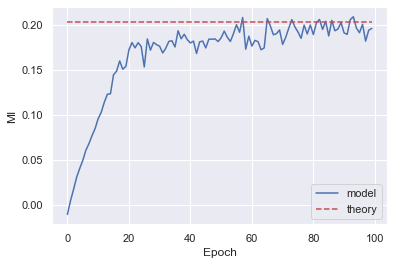

In [45]:
sns.set()
mi_theory = [mi] * len(mi_hist)

plt.plot(range(0, n_epoch), mi_hist, 'b-', label='model')
plt.plot(range(0, n_epoch), mi_theory, 'r--', label='theory')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MI')
plt.show()